In [2]:
#this will take a while as it is getting the most up to date data for you and performing necessary interpolation, as well training the
#model with the updated data
%run pipeline_construction.ipynb

0.0016517570369907356
0.04064181389887434
0.011946259193370577
0.005629112953159713
0.001395602845975046
0.0373577682145902
0.010456107372199942
0.0067072968476141045
0.0026744363674097243
0.051714953034975523
0.01186643846118215


In [8]:
from IPython import display

# Predicting the Federal Funds Target Rate Using Machine Learning

Models mentioned in this notebook can be viewed in the other notebooks of this repository. 
Note: the model in this notebook uses the upper target of the FFTR, however the model still works well for the lower target, this is only applicable to data post 2008, if you would like to change the model to run on the lower target of the FFTR there is documentation detailing how to do so in the pipeline_construction notebook in the make_dataframe function.

# Overview

In the fields of finance and macroeconomics the Federal Funds Target Rate (FFTR) is one of the most studied and important indicators of the state of the US economy. While there have been sucessful models of how the FFTR should move in the past using machine learning, they are outdated and do not account for special circumstances in the economy that arose following the 2008 financial crisis and the 2020 covid pandemic. In this notebook I will outline 2 main models that have the ability to predict changes in the FFTR months in advance with high accuracy. I will compare these models to models based on conventional macroeconomic knowledge to show that there is more that goes into the decision to change the FFTR than classic theory suggests. 

# Data sources

The data used in this project was sourced from FRED (Federal Reserve Economic Database) which is maintained by the Federal Reserve Bank of St. Louis. The API requests used to gather the data can be seen in the pipeline construction notebook. Feature inclusions and preprocessing can be seen in the EDA_Cleaning notebook. The data after I have preprocessed it can be seen below. 

In [4]:
merge_df.head()

,FFTR,gdp_gap,DCOILBRENTEU,DPCCRV1Q225SBEA,DSPIC96,EXPGS,GDP,IMPGS,INDPRO,WM2NS,...,RECPROUSM156N,UNRATE,DEXJPUS,T10Y2Y,1_month_ahead,2_month_ahead,3_month_ahead,1_month_back,2_month_back,3_month_back
date,,,,,,,,,,,,,,,,,,,,,
1987-11-09,6.8125,-0.294146,17.50,4.1,6648.1,392.107,5007.994,537.511,60.0022,2826.4,...,0.06,5.8,134.30,1.140,7.3125,7.25,6.625,6.8125,6.8125,6.625
1987-11-10,6.8125,-0.294146,17.75,4.1,6648.1,392.107,5007.994,537.511,60.0022,2826.2,...,0.06,5.8,134.55,1.180,7.3125,7.25,6.625,6.8125,6.8125,6.625
1987-11-11,6.8125,-0.294146,17.80,4.1,6648.1,392.107,5007.994,537.511,60.0022,2826.0,...,0.06,5.8,135.50,1.155,7.3125,7.25,6.625,6.8125,6.8125,6.625
1987-11-12,6.8125,-0.294146,17.85,4.1,6648.1,392.107,5007.994,537.511,60.0022,2825.8,...,0.06,5.8,136.45,1.130,7.3125,7.25,6.625,6.8125,6.8125,6.625
1987-11-13,6.8125,-0.294146,17.80,4.1,6648.1,392.107,5007.994,537.511,60.0022,2825.6,...,0.06,5.8,135.85,1.090,7.3125,7.25,6.625,6.8125,6.8125,6.500


## Note on Methodology

When going through this notebook it is important to know how the FFTR is determined, and what that means for this project. The FFTR is the interest rate set by the Federal Open Markets Commitee (FOMC) that dictates the rates that banks can borrow from the FED at. This in turn affects the interest rate of every other loan in the country as it changes the math behind what a bank should do with their money. Importantly for us, knowing that the FFTR is determined by a group of people, and not by a natural process, this means that I need to aim to model the process that the FOMC takes to determine the rate, this will change the way that data is interpolated, as well as included features.

# The Taylor Rule

Before we actually get to any modeling it is important to note that there is a theoretical framework that the FOMC uses to determine what the FFTR will be. This framework, called the Taylor rule, was developed in the 1990s as a framework for central banks to determine interest rates. This will serve as our baseline model and will help us to think about ways we can iterate and improve on this model.
|
The equation for the Taylor Rule is:

r = p + .5y + .5(p-2) + 2

where r is the nominal interest rate, p is the gdp gap, and y is the current inflation rate.

## The Zero Lower Bound

Another very important factor to consider when building our model is that we want to avoid the model predicting a rate below 0% at all costs. The reason for this is because in practice the FOMC would never set a negative interest rate as it would mean that they would pay out interest to borrowers, which would instantly collapse the economy. Combined with the fact that for over half a decade following the 2008 financial crisis the FOMC set rates near zero means that our model has to be precise enough to not predict a rate below zero.

# Interpolation strategy

One thing that I had to address before training my model is that not all of my included features have the same time interval when it comes to reporting. The intervals that are present are: quarterly, monthly, weekly, daily with no weekends, and daily including weekends. Keeping in mind that we are not modeling a natural process but rather attempting to model the thinking of the FOMC, a key question arises when we need to impute our data, what interval of data does the FOMC use for their decision making. For weekly and daily without weekend data the length of consecutive nans will be 6 or 2, so it doesn't matter too much if we linearly interpolate them, so we will do so. However, for monthly and quarterly data, if we were to linearly interpolate them we would be making a bad assumption, as the FOMC only has access to data from the past month, so I chose to forward fill the data in these columns to best mimic the thought process of the FOMC.

# My Target

Performance of the model will be evaulated based on the mean average error of predictions on test set. Requires an MAE below .05 of a prediction 3 months out to be useful for bond future market action.

# Models

## Taylor Rule Model

For my baseline model I built a linear regression model using only current FFTR, CPI, and gdp gap, however for comparison purposes I also built a rendom forest model with these features that I will compare my expanded feature set models to. Full performance metrics of this model can be seen in the random_forest and pipeline_construction notebooks. 

As you can see in the mentioned notebooks, our baseline MAE will be .314 and our baseline r2 score will be 96.9%. Keep these numbers in mind when evaluating the performance of our expanded models.

## Sarimax

Before going into my best models I would like to make a note on my attempts to use classical time-series decomposition methods for modeling, and why they failed. When you initally look at the line plot below that plots the FFTR over time you would think that it is perfect for a SARIMAX model. It has seasonality in the form of the 5.5 year macroeconomic cycle, it fulfills the autoregressive component due to it being time series, it has a moving average as we can see the trend going down over time, and there are exogenous variables that I want to include in the model. However, I identified 2 reasons that a sarimax model would not work as well as you would think at a first glance. The first reason is that the zero lower bound stops the seasonal decomposition from being accurate as there are periods (2008-2016) where the FED embraced a near zero interest rate. This led the SARIMAX model to consistently predict sub zero interest rates which is one of the main things we need to avoid in the model. The second thing that led the SARIMAX model to be incorrect is that we are not modeling a natural seasonal cycle, we are modeling an induced cycle based on what the FED thinks is appropriate at the time. This leads the cycle to be irregular, and unnecessary. I say unnecessary due to the fact that we have to keep in mind that we are modeling the thought process of the FOMC, who might consider how long ago the last cycle was, but their decision is ultimately based on the current economic climate. Therefore SARIMAX, which assumes a somewhat regular seasonality, is not applicable to this problem.

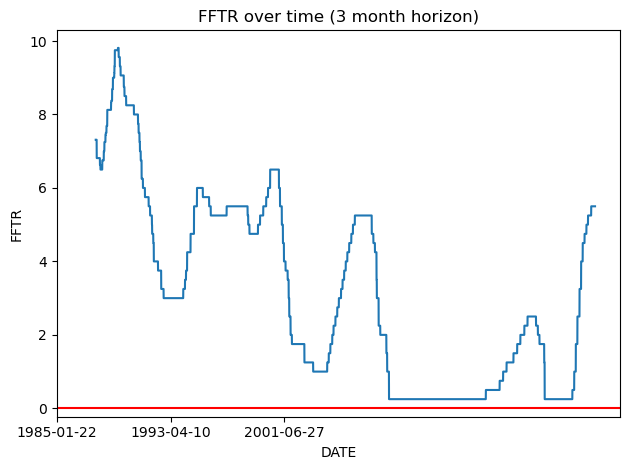

In [20]:
plt.plot(y_1, linestyle = 'solid', label = 'true')
plt.ylabel('FFTR')
plt.title('FFTR over time (3 month horizon)')
plt.xlabel('DATE')
plt.xticks(np.arange(5500, 13440, 3000))
plt.axhline(y = 0, color = 'r', linestyle = '-') 
plt.tight_layout()
plt.savefig('../images/accuracy_by_model.png')
plt.show()

## Random Forest and XGB

Both the XGBoost model and the Random Forest model performed very well so I will be mentioning both of them in this notebook. 

After I figured out that Sarimax was not suited for this problem I looked for a simpler model that doesn't have to rely on a full timeseries decomposition. This led me to exploring a random forest and a gradient boosted trees model. 


To implement these models I had to add 3 new features to aid my model in its predictions. These features were all time lagged versions of past FFTR values at time intervals on 1, 2, and 3 months back. This let me add a time component manually that was more in line with what I thought FOMC was looking at, which is the short term trend of the FFTR. 

After a lot of gridsearching for optimal hyperparameters I found that the best parameters for my random forest were: max_depth of 14, num_estimators of 1200, and a max_features of log2. The best parameters for my XGB model were a max_depth of 10, a learning rate of .1, and a n_estimators of 800. 

While these may seem like very deep trees for the problem at hand, they are necessary to make the models respect the zero lower bound and adjust to near zero interest rates quickly.

The performance metrics for the RFR model were: RMSE of .049, MAE of .0119, r2 of 99.975, and MAPE of .006.
The performance metrics for the XGB model were: RMSE of .048, MAE of .0112, r2 of 99.967, and MAPE of .005.
The metrics for both of these models means that they are viable models for exploiting the government bonds futures market although some risk math would have to be done before I would be able to implement it in a general trading strategy.

Below I have included a visualization of how well the xgb model tracks the FFTR while predicting 3 months out. 

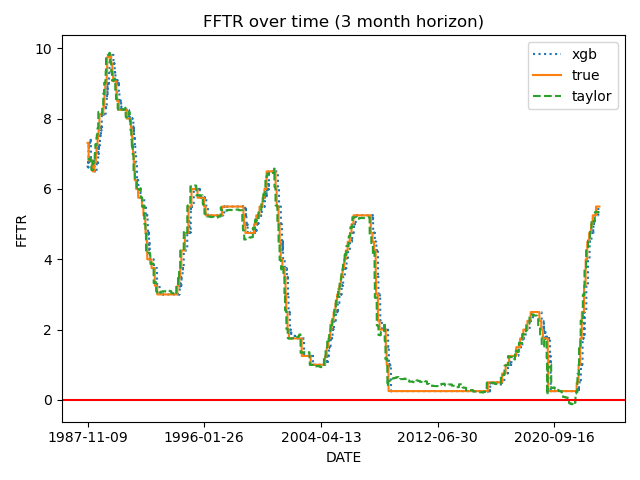

In [9]:
#did not include RFR in this visualization to reduce clutter, it was almost completely overlapped with the XGB line
display.Image("../images/accuracy_by_model.png")

#